# ASEを使ってQE用の構造モデル（Graphite slab, Graphene）を作成する

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
if importlib.util.find_spec("ase") is None:
    !pip install git+https://github.com/minoru-otani/ase.git@qe_rism

In [3]:
import copy
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.constraints import FixAtoms
from ase.io.cube import read_cube_data
from ase.build import fcc111, graphene, add_adsorbate, molecule, cut, add_vacuum
from ase.geometry import wrap_positions
from ase.lattice.hexagonal import Graphite, Graphene

## Grapheneを使ってスラブモデルを作成する

### プリミティブセルを作る

3-1で使ったbuildモジュールにある表面構造を作る関数を用いてgrapheneのモデルを作成する。

In [4]:
lvac = 8.0 # 左の真空領域
rvac = 10.0 # 右の真空領域
vac = (lvac + rvac)/2.0 # grapheneに与えるときは1/2して与える。
gra = graphene(formula='C2', a=2.46, size=(1,1,1), vacuum=vac)
gra.wrap() # はみ出た原子があればユニットセル内に戻す 
gra.translate((0.0,0.0,lvac - vac)) # 与えたlvac, rvacを持つようにずらす

プロットして実際にちゃんとできているかを確認する。

### 大きい表面($3\times 3\sqrt{3}$モデル)を作る。

グラフェンのユニットセルを$\boldsymbol{a}=(a,0)$, $\boldsymbol{b}=(-\frac{1}{2}a, \frac{\sqrt{3}}{2}a)$に対して、新しい表面のユニットセルを$\boldsymbol{A}=\ell_1\boldsymbol{a}+m_1\boldsymbol{b}$, $\boldsymbol{B}=\ell_2\boldsymbol{a}+m_2\boldsymbol{b}$で定義すれば良い。新たな$(\ell_1, m_1)$, $(\ell_2, m_2)$を与えて、cut関数を使う。$\ell_1=3$, $m_1=0$及び、$\ell_2=3$, $m_2=6$を入れれば良い。

In [5]:
slab_sqrt3 = cut(gra, a=(3, 0, 0), b=(3, 6, 0), c=(0, 0, 1))

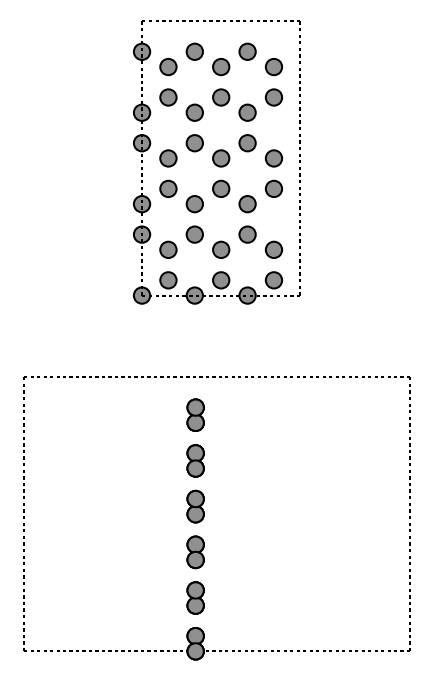

In [6]:
fig, ax = plt.subplots(2,1, figsize=(6, 6))
ax[0].set_axis_off()
ax[1].set_axis_off()
plot_atoms(slab_sqrt3, ax[0], radii=0.5, rotation=('0x,0y,0z'))
plot_atoms(slab_sqrt3, ax[1], radii=0.5, rotation=('90x,90y,90z'))
plt.show()

## Grapheneが積層されたスラブモデルを作る。

### AB-stacking graphiteスラブを作る

まずは、lattice.hexagonalのGrpahite関数を用いてスラブを切り出す。

In [7]:
alat = 2.45 # 面内の格子ベクトル
clat = 5.70 # 面直方向の格子ベクトル
gra_AB = Graphite('C', latticeconstant={'a':alat, 'c':clat}, size=(1,1,1))

格子ベクトル、原子座標を確認する。

In [8]:
aobj = gra_AB
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = (  2.45000,   0.00000,   0.00000)
            b = ( -1.22500,   2.12176,   0.00000)
            c = (  0.00000,   0.00000,   5.70000)
 Number of atoms:     4
 Species, Positions:
  'C ' (  0.00000,   0.00000,   0.00000)
  'C ' (  0.00000,   1.41451,   0.00000)
  'C ' (  0.00000,   1.41451,   2.85000)
  'C ' (  1.22500,   0.70725,   2.85000)


graからスラブを切り出す。ここでは、ABA stackingとABAB stackingのスラブの作り方を示す。

In [9]:
gra_cut = cut(gra_AB, a=(1,0,0), b=(0,1,0), c=(0,0,1.5)) # ABA stackingを作る
#gra_cut = cut(gra_AB, a=(1,0,0), b=(0,1,0), c=(0,0,2.0)) # ABAB stackingを作る

モデルを描画して正しくスラブモデルが作成できているかを確認する。

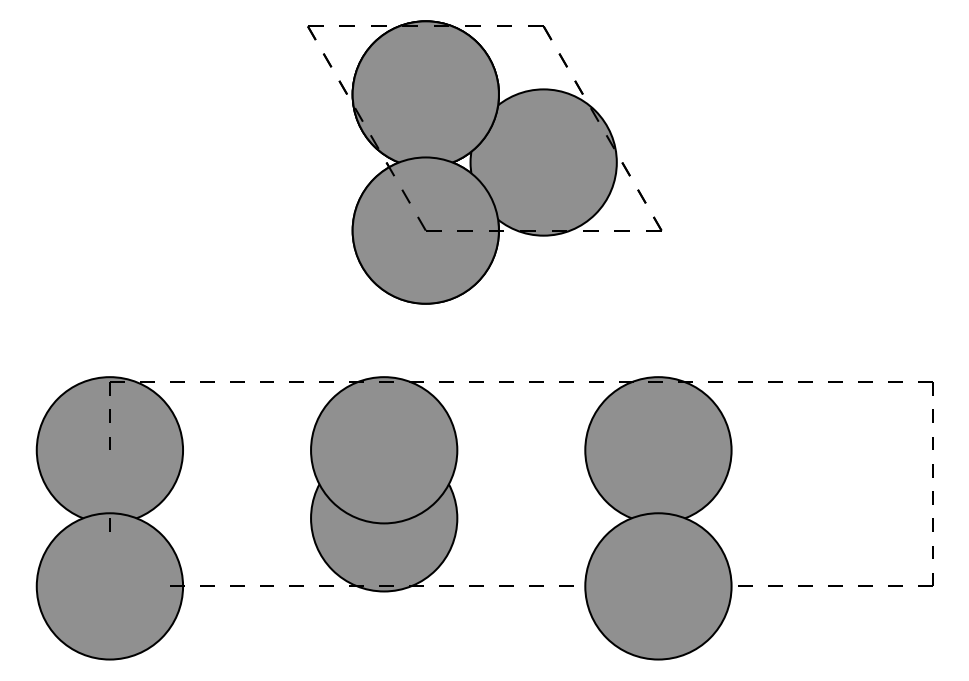

In [10]:
fig, ax = plt.subplots(2,1, figsize=(12, 6))
ax[0].set_axis_off()
ax[1].set_axis_off()
plot_atoms(gra_cut, ax[0], radii=1.0, rotation=('0x,0y,0z'))
plot_atoms(gra_cut, ax[1], radii=1.0, rotation=('90x,90y,90z'))
plt.show()

真空を挿入して、スラブモデルを完成させる。この時に左の真空(```lvac```)と右の真空(```rvac```)がちゃんと設定通りになるようにする。

In [11]:
lvac = 8.0 # 左の真空を8Aとする。
rvac = 10.0 # 右の真空を10Aとする
vac = (lvac+rvac)-clat/2.0
add_vacuum(gra_cut, vac)

ESM/ESM-RISM計算を行うために、原子座標を正しい位置にずらす。

In [12]:
gra_ESM = copy.deepcopy(gra_cut)
gra_ESM.translate((0.0,0.0,-(gra_cut.cell[2,2]/2.0)+lvac))

原子座標が正しくずらされているかを確認する。

In [13]:
aobj = gra_ESM
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = (  2.45000,   0.00000,   0.00000)
            b = ( -1.22500,   2.12176,   0.00000)
            c = (  0.00000,   0.00000,  23.70000)
 Number of atoms:     6
 Species, Positions:
  'C ' (  0.00000,   0.00000,  -3.85000)
  'C ' (  0.00000,   1.41451,  -3.85000)
  'C ' (  0.00000,   1.41451,  -1.00000)
  'C ' (  1.22500,   0.70725,  -1.00000)
  'C ' (  0.00000,   0.00000,   1.85000)
  'C ' (  0.00000,   1.41451,   1.85000)


### AA-stacking graphiteスラブを作る

AA-stackingはGraphite関数を使ってはできないので、Graphene関数を使って手動で層を足す。まずは、Grapheneに入っている原子位置を確認する。

In [14]:
print(Graphene.bravais_basis)

[[0, 0, 0], [0.3333333333333333, 0.6666666666666666, 0]]


原子１は$(0,0,0)$と$(1/3,2/3,0)$の位置に入っている。AA-stackingとなるように$(0,0,1/2)$と$(1/3,2/3,1/2)$に原子を追加する。

In [15]:
Graphene.bravais_basis.append([0,0,1/2])
Graphene.bravais_basis.append([1/3,2/3,1/2])

あとは、AB-stackingと同様に層を切り出してスラブモデルを作る。

In [16]:
alat = 2.45 # 面内の格子ベクトル
clat = 5.70 # 面直方向の格子ベクトル
gra_AA = Graphene('C', latticeconstant={'a':alat, 'c':clat}, size=(1,1,1))

格子ベクトル、原子座標を確認する。

In [17]:
aobj = gra_AA
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = (  2.45000,   0.00000,   0.00000)
            b = ( -1.22500,   2.12176,   0.00000)
            c = (  0.00000,   0.00000,   5.70000)
 Number of atoms:     4
 Species, Positions:
  'C ' (  0.00000,   0.00000,   0.00000)
  'C ' (  0.00000,   1.41451,   0.00000)
  'C ' (  0.00000,   0.00000,   2.85000)
  'C ' (  0.00000,   1.41451,   2.85000)


graからスラブを切り出す。ここでは、AAA stackingスラブの作り方を示す。

In [18]:
gra_cut = cut(gra_AA, a=(1,0,0), b=(0,1,0), c=(0,0,1.5)) # AAA stackingを作る

モデルを描画して正しくスラブモデルが作成できているかを確認する。

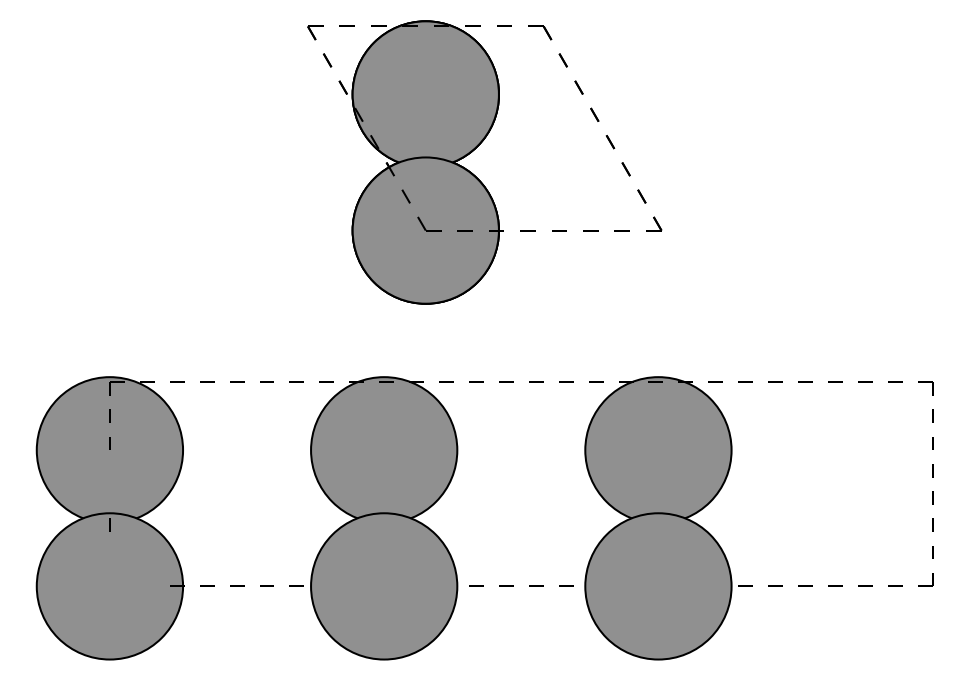

In [19]:
fig, ax = plt.subplots(2,1, figsize=(12, 6))
ax[0].set_axis_off()
ax[1].set_axis_off()
plot_atoms(gra_cut, ax[0], radii=1.0, rotation=('0x,0y,0z'))
plot_atoms(gra_cut, ax[1], radii=1.0, rotation=('90x,90y,90z'))
plt.show()

真空を挿入して、スラブモデルを完成させる。この時に左の真空(```lvac```)と右の真空(```rvac```)がちゃんと設定通りになるようにする。

In [20]:
lvac = 8.0 # 左の真空を8Aとする。
rvac = 10.0 # 右の真空を10Aとする
vac = (lvac+rvac)-clat/2.0
add_vacuum(gra_cut, vac)

ESM/ESM-RISM計算を行うために、原子座標を正しい位置にずらす。

In [21]:
gra_ESM = copy.deepcopy(gra_cut)
gra_ESM.translate((0.0,0.0,-(gra_cut.cell[2,2]/2.0)+lvac))

原子座標が正しくずらされているかを確認する。

In [22]:
aobj = gra_ESM
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = (  2.45000,   0.00000,   0.00000)
            b = ( -1.22500,   2.12176,   0.00000)
            c = (  0.00000,   0.00000,  23.70000)
 Number of atoms:     6
 Species, Positions:
  'C ' (  0.00000,   0.00000,  -3.85000)
  'C ' (  0.00000,   1.41451,  -3.85000)
  'C ' (  0.00000,   0.00000,  -1.00000)
  'C ' (  0.00000,   1.41451,  -1.00000)
  'C ' (  0.00000,   0.00000,   1.85000)
  'C ' (  0.00000,   1.41451,   1.85000)


Graphene関数を使い回すことを考えて、追加した原子を削除して元の状態に戻しておく。2原子分の座標を追加したので、Grapheneのbaravais_basisには0~3のindexの原子が入っている。2と３を消す。リストから要素を削除する場合は```del```を使うと便利だが、スライスの与え方に注意が必要。```del list[start:end:interval]```で与えるが、削除されindexはstart$\leq$index$<$endなので、3番目も削除する場合にはスライスを```[2:4]```と与える必要がある。

In [23]:
del Graphene.bravais_basis[2:4:1]
print(Graphene.bravais_basis)

[[0, 0, 0], [0.3333333333333333, 0.6666666666666666, 0]]


### ABC-stacking graphiteスラブを作る

ABC-stackingもGraphite関数を使ってはできないので、Graphene関数を使って手動で層を足す。まずは、Grapheneに入っている原子位置を確認する。

Grapheneの原子位置に対して、B層$((1/3,2/3,1/3)$, $(2/3,1/3,1/3)$)を足して、さらにC層($(2/3,1/3,2/3)$と$(0,0,2/3)$に原子を追加する。

In [24]:
Graphene.bravais_basis.append([1/3, 2/3, 1/3])
Graphene.bravais_basis.append([2/3, 1/3, 1/3])
Graphene.bravais_basis.append([2/3, 1/3, 2/3])
Graphene.bravais_basis.append([0, 0, 2/3])

あとは、ABC-stackingと同様に層を切り出してスラブモデルを作る。

In [25]:
alat = 2.45 # 面内の格子ベクトル
clat = 5.70 # 面直方向の格子ベクトル
gra_ABC = Graphene('C', latticeconstant={'a':alat, 'c':clat+clat/2.0}, size=(1,1,1)) # C層が足されているので、ユニットセルも増やす

格子ベクトル、原子座標を確認する。

In [26]:
aobj = gra_ABC
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = (  2.45000,   0.00000,   0.00000)
            b = ( -1.22500,   2.12176,   0.00000)
            c = (  0.00000,   0.00000,   8.55000)
 Number of atoms:     6
 Species, Positions:
  'C ' (  0.00000,   0.00000,   0.00000)
  'C ' (  0.00000,   1.41451,   0.00000)
  'C ' (  0.00000,   1.41451,   2.85000)
  'C ' (  1.22500,   0.70725,   2.85000)
  'C ' (  1.22500,   0.70725,   5.70000)
  'C ' (  0.00000,   0.00000,   5.70000)


graからスラブを切り出す。ここでは、ABCA stackingスラブの作り方を示す。

In [27]:
gra_cut = cut(gra_ABC, a=(1,0,0), b=(0,1,0), c=(0,0,4/3)) # ABCA stackingを作る

モデルを描画して正しくスラブモデルが作成できているかを確認する。

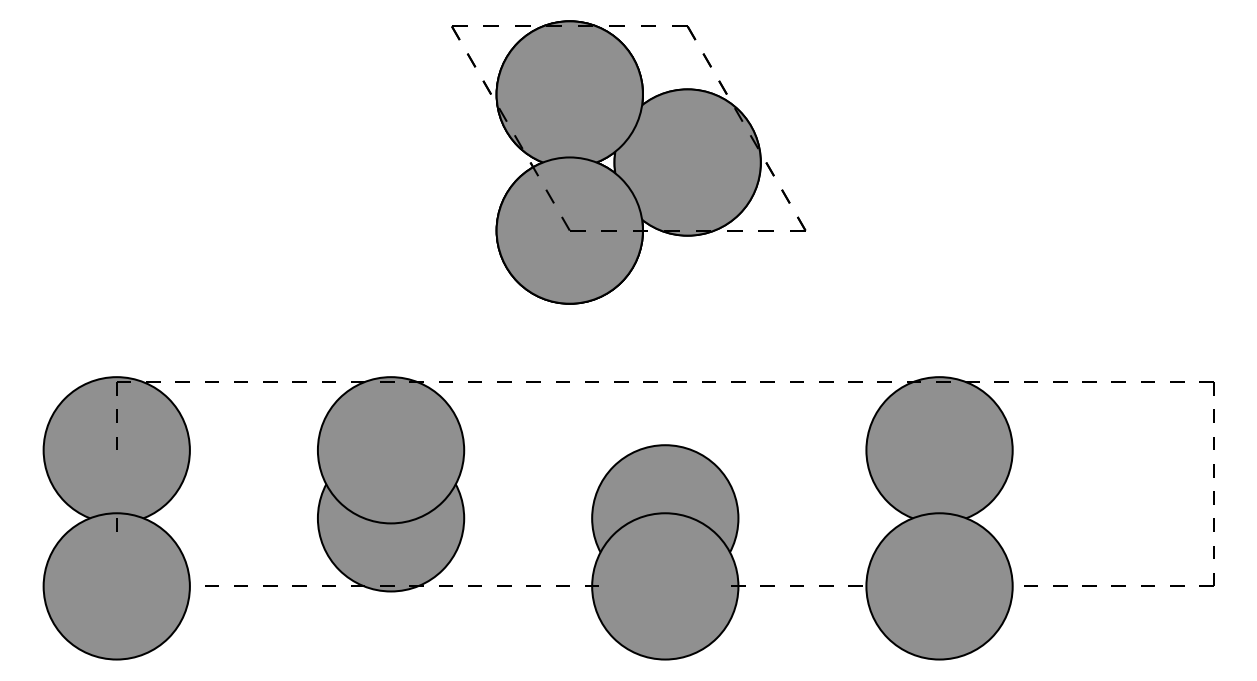

In [28]:
fig, ax = plt.subplots(2,1, figsize=(12, 6))
ax[0].set_axis_off()
ax[1].set_axis_off()
plot_atoms(gra_cut, ax[0], radii=1.0, rotation=('0x,0y,0z'))
plot_atoms(gra_cut, ax[1], radii=1.0, rotation=('90x,90y,90z'))
plt.show()

真空を挿入して、スラブモデルを完成させる。この時に左の真空(```lvac```)と右の真空(```rvac```)がちゃんと設定通りになるようにする。

In [29]:
lvac = 8.0 # 左の真空を8Aとする。
rvac = 10.0 # 右の真空を10Aとする
vac = (lvac+rvac)-clat/2.0
add_vacuum(gra_cut, vac)

ESM/ESM-RISM計算を行うために、原子座標を正しい位置にずらす。

In [30]:
gra_ESM = copy.deepcopy(gra_cut)
gra_ESM.translate((0.0,0.0,-(gra_cut.cell[2,2]/2.0)+lvac))

原子座標が正しくずらされているかを確認する。

In [31]:
aobj = gra_ESM
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = (  2.45000,   0.00000,   0.00000)
            b = ( -1.22500,   2.12176,   0.00000)
            c = (  0.00000,   0.00000,  26.55000)
 Number of atoms:     8
 Species, Positions:
  'C ' (  0.00000,   0.00000,  -5.27500)
  'C ' (  0.00000,   1.41451,  -5.27500)
  'C ' (  0.00000,   1.41451,  -2.42500)
  'C ' (  1.22500,   0.70725,  -2.42500)
  'C ' (  1.22500,   0.70725,   0.42500)
  'C ' (  0.00000,   0.00000,   0.42500)
  'C ' (  0.00000,   0.00000,   3.27500)
  'C ' (  0.00000,   1.41451,   3.27500)


# Tips

色々な関数を使う時に何を引数に取ってくれるのか分からないことが多い。その場合はsource codeを見に行くことになるが、簡単に引数を確認するだけなら以下の方法が便利

In [32]:
from inspect import signature
signature(Graphite)

<Signature (symbol, directions=(None, None, None), miller=(None, None, None), size=(1, 1, 1), latticeconstant=None, pbc=True, align=True, debug=0)>

In [33]:
from inspect import signature
signature(Graphene)

<Signature (symbol, directions=(None, None, None), miller=(None, None, None), size=(1, 1, 1), latticeconstant=None, pbc=True, align=True, debug=0)>

In [34]:
signature(cut)

<Signature (atoms, a=(1, 0, 0), b=(0, 1, 0), c=None, clength=None, origo=(0, 0, 0), nlayers=None, extend=1.0, tolerance=0.01, maxatoms=None)>